# **Edge Detection Tools**

# **Libraries**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans




# **Mean Shifting**

Number of clusters found: 3


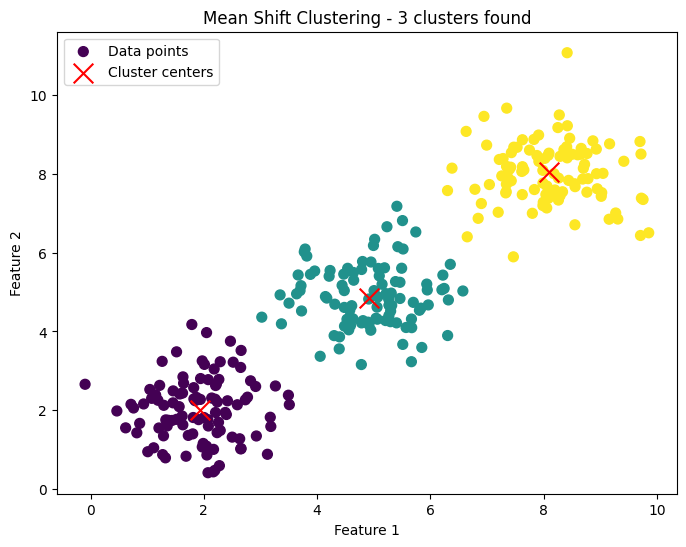

In [ ]:

centers = [[2, 2], [8, 8], [5, 5]]  
X, _ = make_blobs(n_samples=300, centers=centers, cluster_std=0.8, random_state=42)


mean_shift = MeanShift(bandwidth=2)  


mean_shift.fit(X)

labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_


n_clusters = len(np.unique(labels))
print(f'Number of clusters found: {n_clusters}')


plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50, label='Data points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster centers')
plt.title(f'Mean Shift Clustering - {n_clusters} clusters found')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:


centers = [[2, 2], [8, 8], [5, 5]]  
X, _ = make_blobs(n_samples=300, centers=centers, cluster_std=0.8, random_state=42)

mean_shift = MeanShift(bandwidth=2)  

mean_shift.fit(X)

labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_

n_clusters = len(np.unique(labels))
print(f'Number of clusters found: {n_clusters}')

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', s=50, label='Data points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Cluster centers')
plt.title(f'Mean Shift Clustering - {n_clusters} clusters found')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:

bw = cv2.imread('./noise2.png', 0)
height, width = bw.shape[0:2]
cv2.imshow("Original BW", bw)

binary = np.zeros([height, width, 1], 'uint8')

thresh = 85

for row in range(0, height):
    for col in range(0, width):
        if bw[row][col] > thresh:
            binary[row][col] = 255

cv2.imshow("Slow Binary", binary)

cv2.waitKey(0)
cv2.destroyAllWindows()

# **Adaptive Thresholding**

In [ ]:


img = cv2.imread('./noise2.png', 0)
cv2.imshow("Original", img)


ret, thresh_basic = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
cv2.imshow("Basic Binary", thresh_basic)

thres_adapt = cv2.adaptiveThreshold(
    img, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    11,
    2
)
cv2.imshow("Adaptive Threshold", thres_adapt)

cv2.waitKey(0)
cv2.destroyAllWindows()

Running complete pipeline with K-means...
Step 1: Extracting orange color using K-means...
Step 2: Applying contrast enhancement and adaptive thresholding...
Step 3: Removing noise...


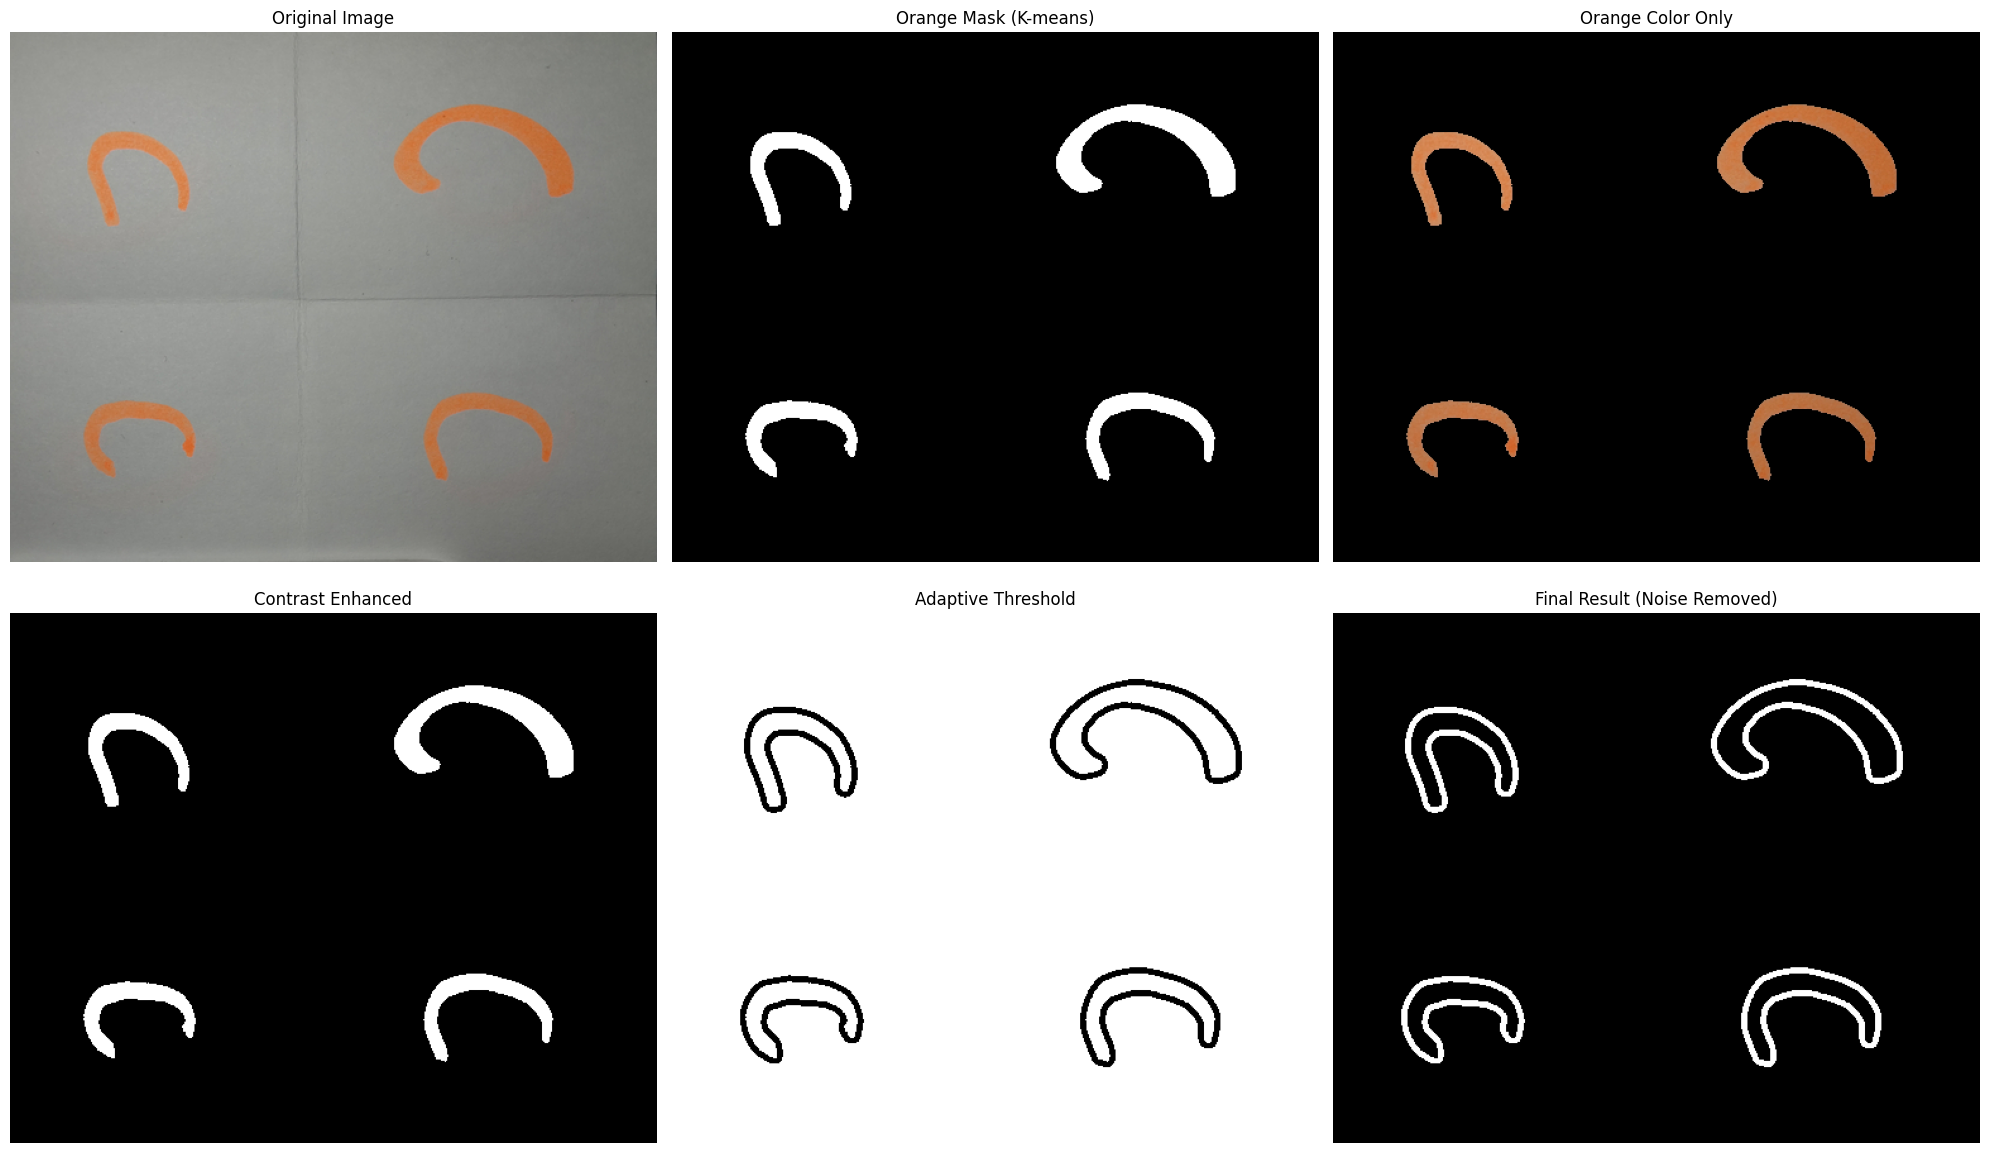


Running simplified HSV-based approach...


In [ ]:


def extract_orange_color_kmeans(image_path, n_clusters=3):
    """Extract orange color using K-means clustering"""
    # Read the image in BGR format
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape image to be a list of pixels
    pixels = image_rgb.reshape(-1, 3)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    
    # Find the cluster that represents orange color
    # Orange is typically high in red, medium in green, low in blue
    cluster_centers = kmeans.cluster_centers_
    
    # Calculate "orangeness" score for each cluster
    orangeness_scores = []
    for center in cluster_centers:
        r, g, b = center
        # Orange has high red, medium green, low blue
        score = r - abs(g - 120) - b  # Adjust weights as needed
        orangeness_scores.append(score)
    
    # Select the most orange cluster
    orange_cluster = np.argmax(orangeness_scores)
    
    # Create mask for orange pixels
    labels = kmeans.labels_.reshape(image_rgb.shape[0], image_rgb.shape[1])
    orange_mask = (labels == orange_cluster).astype(np.uint8) * 255
    
    # Apply mask to original image
    orange_only = cv2.bitwise_and(image_rgb, image_rgb, mask=orange_mask)
    
    return orange_mask, orange_only, image_rgb

def enhance_contrast_and_threshold(mask):
    """Enhance contrast and apply adaptive thresholding"""
    # Convert mask to grayscale if it's not already
    if len(mask.shape) == 3:
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    else:
        mask_gray = mask
    
    # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(mask_gray)
    
    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        contrast_enhanced, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    
    return adaptive_thresh, contrast_enhanced

def remove_noise(binary_image):
    """Remove noise using morphological operations"""
    # Define kernel for morphological operations
    kernel = np.ones((3,3), np.uint8)
    
    # Apply opening (erosion followed by dilation) to remove small noise
    cleaned = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    
    # Apply closing (dilation followed by erosion) to fill small holes
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    
    # Optional: Remove small connected components
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    
    # Minimum size of particles we want to keep (adjust based on your image)
    min_size = 50
    
    cleaned_final = np.zeros_like(cleaned)
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            cleaned_final[output == i + 1] = 255
    
    return cleaned_final

def complete_pipeline(image_path):
    """Complete pipeline for orange text extraction"""
    # Step 1: Extract orange color using K-means
    print("Step 1: Extracting orange color using K-means...")
    orange_mask, orange_only, original = extract_orange_color_kmeans(image_path)
    
    # Step 2: Enhance contrast and apply adaptive thresholding
    print("Step 2: Applying contrast enhancement and adaptive thresholding...")
    adaptive_thresh, contrast_enhanced = enhance_contrast_and_threshold(orange_mask)
    
    # Step 3: Remove noise
    print("Step 3: Removing noise...")
    final_result = remove_noise(adaptive_thresh)
    
    # Convert to black background with white text
    final_black_bg = cv2.bitwise_not(final_result)
    
    # Display results
    plt.figure(figsize=(20, 12))
    
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(orange_mask, cmap='gray')
    plt.title('Orange Mask (K-means)')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(orange_only)
    plt.title('Orange Color Only')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(contrast_enhanced, cmap='gray')
    plt.title('Contrast Enhanced')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(adaptive_thresh, cmap='gray')
    plt.title('Adaptive Threshold')
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(final_black_bg, cmap='gray')
    plt.title('Final Result (Noise Removed)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return final_black_bg, orange_mask, adaptive_thresh

# Alternative simpler function using your existing code structure
def simple_orange_extraction(image_path):
    """Simplified version using color range detection"""
    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define orange color range in HSV (more robust than RGB)
    # Adjust these values based on your specific orange color
    lower_orange = np.array([5, 100, 100])    # Lower bound for orange
    upper_orange = np.array([15, 255, 255])   # Upper bound for orange
    
    # Create mask for orange color
    orange_mask = cv2.inRange(image_hsv, lower_orange, upper_orange)
    
    # Apply mask
    orange_only = cv2.bitwise_and(image_rgb, image_rgb, mask=orange_mask)
    
    # Convert to grayscale for thresholding
    gray = cv2.cvtColor(orange_only, cv2.COLOR_RGB2GRAY)
    
    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    
    # Remove noise
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel)
    
    # Invert to get black background
    final_result = cv2.bitwise_not(cleaned)
    
    return final_result, orange_mask, adaptive_thresh

# Usage example:
if __name__ == "__main__":
    image_path = './noise2.png'  # Replace with your image path
    
    # Method 1: Complete pipeline with K-means
    print("Running complete pipeline with K-means...")
    final_result, orange_mask, adaptive_thresh = complete_pipeline(image_path)
    
    # Method 2: Simpler HSV-based approach (often more reliable for color detection)
    print("\nRunning simplified HSV-based approach...")
    final_simple, orange_mask_simple, adaptive_simple = simple_orange_extraction(image_path)
    
    # Display comparison
    cv2.imshow("K-means Result", final_result)
    cv2.imshow("HSV-based Result", final_simple)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

def extract_orange_kmeans(image_path, n_clusters=3):
    """Extract only orange parts using K-means and remove everything else with white background"""
    
    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape image to be a list of pixels
    pixels = image_rgb.reshape(-1, 3)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    
    # Get cluster centers and labels
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_.reshape(image_rgb.shape[0], image_rgb.shape[1])
    
    # Find the most orange cluster
    # Orange typically has high red, medium green, low blue
    orangeness_scores = []
    for center in cluster_centers:
        r, g, b = center
        # Higher score means more orange-like
        score = r * 0.8 - g * 0.5 - b * 0.3
        orangeness_scores.append(score)
    
    orange_cluster_idx = np.argmax(orangeness_scores)
    
    # Create result image with white background
    result = np.ones_like(image_rgb) * 255  # White background
    
    # Copy only orange pixels from original image
    orange_mask = labels == orange_cluster_idx
    result[orange_mask] = image_rgb[orange_mask]
    
    return result, orange_mask

# Usage
image_path = './noise2.png'  # Your image path

# Extract orange parts
orange_only_image, mask = extract_orange_kmeans(image_path)

# Display results
cv2.imshow("Original", cv2.imread(image_path))
cv2.imshow("Orange Only (White Background)", cv2.cvtColor(orange_only_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result if needed
cv2.imwrite('orange_only_white_bg.png', cv2.cvtColor(orange_only_image, cv2.COLOR_RGB2BGR))

True

In [ ]:

image = cv2.imread('./noise2.png')  # Replace with your image path
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Method 1: Using color thresholding (recommended for specific color conversion)
def convert_orange_to_black_threshold(image):
    # Convert to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for orange color in HSV
    # Orange hue is typically between 5-20 in OpenCV HSV (0-180 range)
    lower_orange1 = np.array([5, 100, 100])
    upper_orange1 = np.array([15, 255, 255])
    
    # Create mask for orange color
    mask = cv2.inRange(hsv, lower_orange1, upper_orange1)
    
    # Convert orange pixels to black in the original image
    result = image.copy()
    result[mask > 0] = [0, 0, 0]  # Set to black in BGR
    
    return result

result_image = convert_orange_to_black_threshold(image)

# Save the result
cv2.imwrite('output.png', result_image)

print("Image processed successfully! Orange color converted to black.")

Image processed successfully! Orange color converted to black.


## Adaptive Thresholdding

In [ ]:

img = cv2.imread('./output.png', 0)
cv2.imshow("Original", img)

ret, thresh_basic = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY)
cv2.imshow("Basic Binary", thresh_basic)


thres_adapt = cv2.adaptiveThreshold(
    img, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    11,
    2
)
cv2.imshow("Adaptive Threshold", thres_adapt)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
import cv2

# Read the image in grayscale
img = cv2.imread('./output.png', 0)
cv2.imshow("Original", img)

# Apply basic binary threshold
ret, thresh_basic = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY)
cv2.imshow("Basic Binary", thresh_basic)

cv2.waitKey(0)
cv2.destroyAllWindows()